Models were developed to predict pesticide residue levels in the supply chains of lentils. The model input included a combination of categorical and numerical variables. Contamination level was used as model output, indicating whether the pesticide residue levels exceeded the limit of quantification as a binary variable. Separate models were constructed for each supply chain, utilizing monitoring data sourced from different repositories. The maize supply chain model utilized data from AGROKNOW . As a data preprocessing step, the categorical variables were encoded using one-hot encoding. This is a step to translate the categorical variables into a numerical encoding, which is needed because many machine learning algorithms can't handle categorical input.  

Several machine learning algorithms were implemented to make pesticide residual predictions, namely Random Forest, XGBoost, CatBoost and Support Vector Machine. These models were selected for their historic success in classification problems with structured data. The dataset was randomly split into 80% for the training set and 20% for the test set to train and evaluate the models' performance, respectively. External validation using a different year than present in the training data to show the model's generalizability was not yet performed. In future steps, external validation will be applied for the final model performance evaluation. During training, the algorithms were trained using a class weighted approach where data from the minority class was weighed more than data from the majority class when there was a big class imbalance (maize and lentils). This technique ensures that the algorithms don't develop a bias for the majority class. The model performance is measured using the number of true negatives, false negatives, true positives, false positives and the overall accuracy of the model. The accuracy of the model is calculated by summing the number of true negatives and true positives and dividing it by the total number of predictions.

Monitoring records were not evenly distributed from 2015 to 2020. The most data was collected in 2017 followed by 2020, and the least data was collected in 2015 and 2016. Most monitoring records originated from Canada, France, and Turkey. Figure 3.3 shows the best result from the machine learning modelson the test set using a confusion matrix. The best result was provided by the XGBoost model. Out of 3935 measurements below the LOQ, 3128 measurements were classified as true negatives and 807 measurements were classified as false positives. A total of 10295 measurements had a value above the LOQ, of which 10238 were classified as true positives and 57 were classified as false negatives. This results in an overall accuracy of 93.9%.

Note that this model is a preliminary version and has not undergone external validation due to the limited data available. The model will be updated and validated as more data becomes available.

In [33]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.gridspec as gridspec
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
from sklearn.utils import class_weight  
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, f1_score, precision_score

In [34]:
# Change directory to the location of the data file
Xy=pd.read_csv(r'C:\Users\wang331\OneDrive - Wageningen University & Research\Documents\PHD palace\paper\chapter 24 Holi food\data\holifood-main\processed agroknow data\Agroknow_lentils_data_with_indices_pesticides.csv')
Xy["year"].unique()

array([2020, 2019, 2018, 2017, 2016, 2015], dtype=int64)

In [36]:
# Select relevant columns for analysis
Xy1=Xy[['exceeding_loq',
 'hazard',
 'year',
 'month',
 'origin_code3',
 'notified_code3',
 'volume_avg',
 'price_avg',
 'volume_sum',
 'price_sum',
 'continent',
 'corruption_index',
 'human_development_index',
 'control_corruption',
 'government_effectiveness',
 'political_stability',
 'regulatory_quality',
 'rule_of_law',
 'voice_and_accountability',
 'governance_index',
 'press_freedom_index',
 'democracy_index',
 'polity_democracy_index',
 'gdp_current',
 'gdp_growth',
 'legal_system',
 'food_security_index',
 'innovation_index',]]

Xy1.head()

,exceeding_loq,hazard,year,month,origin_code3,notified_code3,volume_avg,price_avg,volume_sum,price_sum,continent,corruption_index,human_development_index,control_corruption,government_effectiveness,political_stability,regulatory_quality,rule_of_law,voice_and_accountability,governance_index,press_freedom_index,democracy_index,polity_democracy_index,gdp_current,gdp_growth,legal_system,food_security_index,innovation_index
0,0,bromophos-ethyl,2020,10.0,USA,DEU,3567.037500,192151.916667,42804.45,2305823.0,north america,67.0,0.920,1.07,1.31,0.03,1.25,1.36,0.87,0.981667,23.85,7.92,5.0,2.106050e+13,-2.768,NaN,80.0,60.6
1,0,"fluvalinate, tau-",2020,10.0,CAN,DEU,9063.083333,720163.333333,108757.00,8641960.0,north america,77.0,0.931,1.59,1.64,1.03,1.60,1.65,1.48,1.498333,15.29,9.24,NaN,1.645420e+12,-5.233,NaN,78.0,52.3
2,0,fluxapyroxad,2020,10.0,CAN,DEU,9063.083333,720163.333333,108757.00,8641960.0,north america,77.0,0.931,1.59,1.64,1.03,1.60,1.65,1.48,1.498333,15.29,9.24,NaN,1.645420e+12,-5.233,NaN,78.0,52.3
3,0,iprodione,2020,10.0,CAN,DEU,9063.083333,720163.333333,108757.00,8641960.0,north america,77.0,0.931,1.59,1.64,1.03,1.60,1.65,1.48,1.498333,15.29,9.24,NaN,1.645420e+12,-5.233,NaN,78.0,52.3
4,0,diazinon,2020,10.0,CAN,DEU,9063.083333,720163.333333,108757.00,8641960.0,north america,77.0,0.931,1.59,1.64,1.03,1.60,1.65,1.48,1.498333,15.29,9.24,NaN,1.645420e+12,-5.233,NaN,78.0,52.3


In [13]:
# Plot distributions of selected columns

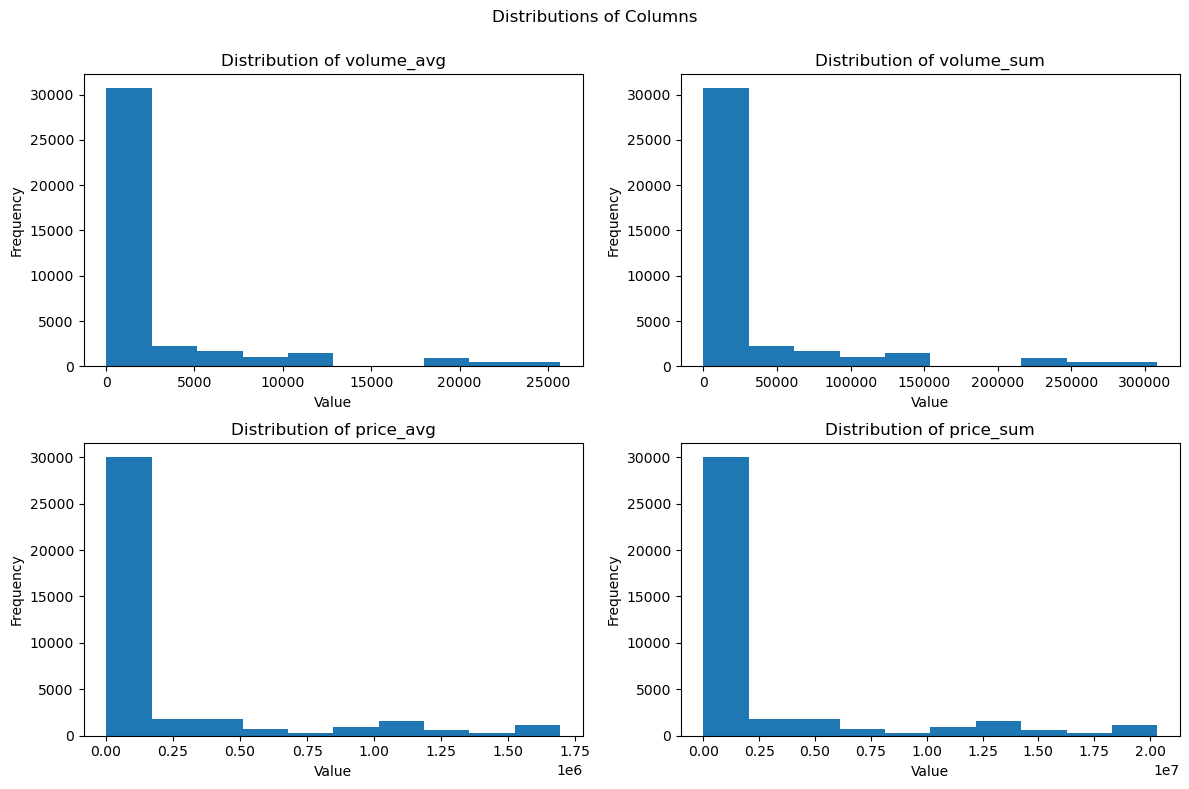

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Distributions of Columns')
columns_to_plot = ['volume_avg', 'volume_sum', 'price_avg', 'price_sum']
for i, column in enumerate(columns_to_plot):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    Xy[column].plot(kind='hist', ax=ax, bins=10)  # You can adjust the number of bins as needed
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {column}')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [38]:
columns_to_describe = ['volume_avg', 'volume_sum', 'price_avg', 'price_sum']
statistics = Xy[columns_to_describe].describe()
statistics

,volume_avg,volume_sum,price_avg,price_sum
count,39239.000000,39239.000000,3.923900e+04,3.923900e+04
mean,2614.776986,30840.666470,2.202766e+05,2.602344e+06
std,5326.262887,64138.662616,4.154642e+05,5.004253e+06
min,13.742500,46.550000,1.424500e+03,4.097000e+03
25%,136.000000,1213.320000,1.289936e+04,9.687300e+04
50%,233.775833,2146.530000,2.078533e+04,1.486150e+05
75%,1718.933333,20627.200000,1.097045e+05,1.316454e+06
max,25693.465000,308321.580000,1.693594e+06,2.032312e+07


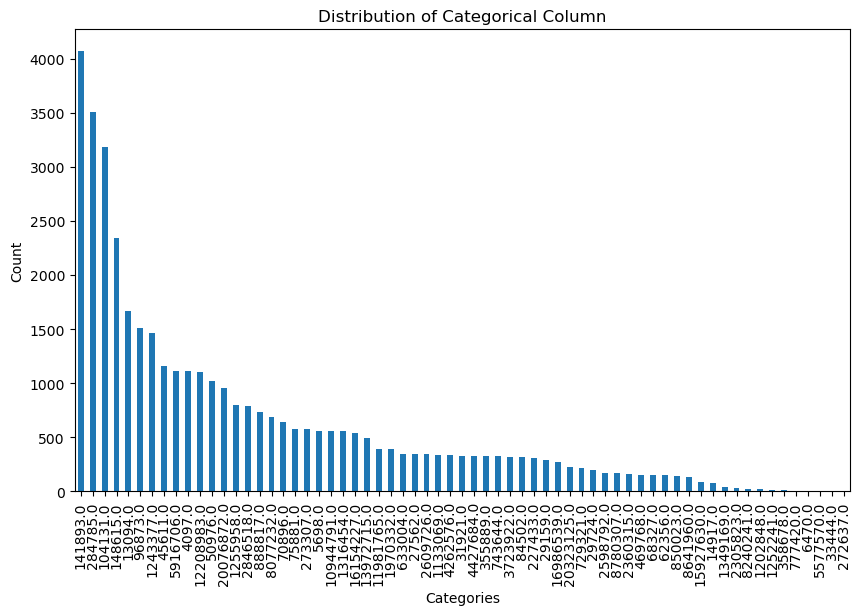

In [39]:
pd.set_option('display.max_columns', None) 
statistics = Xy.describe()
plt.figure(figsize=(10, 6))
Xy['price_sum'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Categorical Column')
plt.show()

In [40]:
count_grouped = Xy1.groupby(["year", "exceeding_loq"]).size().reset_index(name="count")#"origin_code3",
sorted_count_grouped = count_grouped.sort_values(by="year", ascending=False)
sorted_count_grouped

,year,exceeding_loq,count
9,2020,0,2303
10,2020,1,21155
7,2019,0,515
8,2019,1,4036
5,2018,0,781
6,2018,1,4011
3,2017,0,16140
4,2017,1,19907
1,2016,0,1
2,2016,1,1435


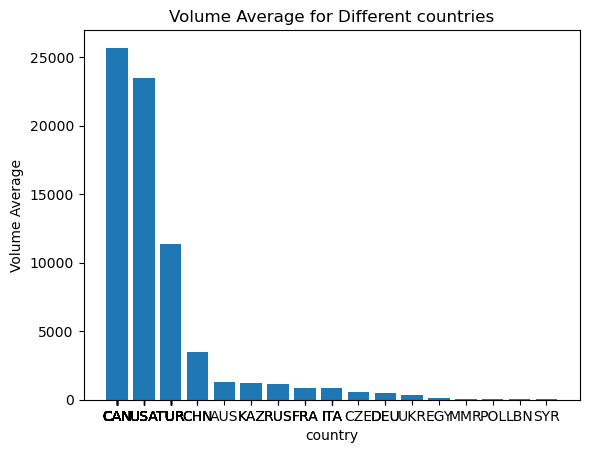

In [41]:
pd.set_option('display.max_rows', 100)
count_grouped = Xy1.groupby(["year","origin_code3", "volume_avg"]).size().reset_index(name="count")
sorted_count_grouped = count_grouped.sort_values(by="volume_avg", ascending=False)
sorted_count_grouped
plt.bar(sorted_count_grouped['origin_code3'], sorted_count_grouped['volume_avg'])
plt.xlabel('country')
plt.ylabel('Volume Average')
plt.title('Volume Average for Different countries')
plt.xticks(sorted_count_grouped['origin_code3'])
plt.show()

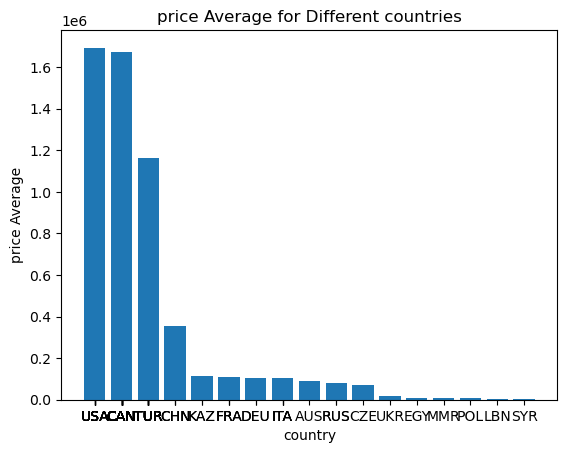

In [42]:
pd.set_option('display.max_rows', 100)
count_grouped = Xy1.groupby(["year","origin_code3", "price_avg"]).size().reset_index(name="count")
sorted_count_grouped = count_grouped.sort_values(by="price_avg", ascending=False)
sorted_count_grouped
plt.bar(sorted_count_grouped['origin_code3'], sorted_count_grouped['price_avg'])
plt.xlabel('country')
plt.ylabel('price Average')
plt.title('price Average for Different countries')
plt.xticks(sorted_count_grouped['origin_code3'])
plt.show()

In [43]:
# Define desired column order
desired_order = [
 'hazard',
 'year',
 'month',
 'origin_code3',
 'notified_code3',
 'volume_avg',
 'price_avg',
 'volume_sum',
 'price_sum',
 'continent',
 'corruption_index',
 'human_development_index',
 'control_corruption',
 'government_effectiveness',
 'political_stability',
 'regulatory_quality',
 'rule_of_law',
 'voice_and_accountability',
 'governance_index',
 'press_freedom_index',
 'democracy_index',
 'polity_democracy_index',
 'gdp_current',
 'gdp_growth',
 'legal_system',
 'food_security_index',
 'innovation_index',
 'temperature_max_mean_1',
 'temperature_max_mean_2',
 'temperature_max_mean_3',
 'temperature_max_mean_4',
 'temperature_max_mean_5',
 'temperature_max_mean_6',
 'temperature_max_mean_7',
 'temperature_max_mean_8',
 'temperature_max_mean_9',
 'temperature_max_mean_10',
 'temperature_max_mean_11',
 'temperature_max_mean_12',
 'temperature_max_sum_1',
 'temperature_max_sum_2',
 'temperature_max_sum_3',
 'temperature_max_sum_4',
 'temperature_max_sum_5',
 'temperature_max_sum_6',
 'temperature_max_sum_7',
 'temperature_max_sum_8',
 'temperature_max_sum_9',
 'temperature_max_sum_10',
 'temperature_max_sum_11',
 'temperature_max_sum_12',
 'temperature_mean_mean_1',
 'temperature_mean_mean_2',
 'temperature_mean_mean_3',
 'temperature_mean_mean_4',
 'temperature_mean_mean_5',
 'temperature_mean_mean_6',
 'temperature_mean_mean_7',
 'temperature_mean_mean_8',
 'temperature_mean_mean_9',
 'temperature_mean_mean_10',
 'temperature_mean_mean_11',
 'temperature_mean_mean_12',
 'temperature_mean_sum_1',
 'temperature_mean_sum_2',
 'temperature_mean_sum_3',
 'temperature_mean_sum_4',
 'temperature_mean_sum_5',
 'temperature_mean_sum_6',
 'temperature_mean_sum_7',
 'temperature_mean_sum_8',
 'temperature_mean_sum_9',
 'temperature_mean_sum_10',
 'temperature_mean_sum_11',
 'temperature_mean_sum_12',
 'temperature_min_mean_1',
 'temperature_min_mean_2',
 'temperature_min_mean_3',
 'temperature_min_mean_4',
 'temperature_min_mean_5',
 'temperature_min_mean_6',
 'temperature_min_mean_7',
 'temperature_min_mean_8',
 'temperature_min_mean_9',
 'temperature_min_mean_10',
 'temperature_min_mean_11',
 'temperature_min_mean_12',
 'temperature_min_sum_1',
 'temperature_min_sum_2',
 'temperature_min_sum_3',
 'temperature_min_sum_4',
 'temperature_min_sum_5',
 'temperature_min_sum_6',
 'temperature_min_sum_7',
 'temperature_min_sum_8',
 'temperature_min_sum_9',
 'temperature_min_sum_10',
 'temperature_min_sum_11',
 'temperature_min_sum_12',
 'precipitation_mean_mean_1',
 'precipitation_mean_mean_2',
 'precipitation_mean_mean_3',
 'precipitation_mean_mean_4',
 'precipitation_mean_mean_5',
 'precipitation_mean_mean_6',
 'precipitation_mean_mean_7',
 'precipitation_mean_mean_8',
 'precipitation_mean_mean_9',
 'precipitation_mean_mean_10',
 'precipitation_mean_mean_11',
 'precipitation_mean_mean_12',
 'precipitation_mean_sum_1',
 'precipitation_mean_sum_2',
 'precipitation_mean_sum_3',
 'precipitation_mean_sum_4',
 'precipitation_mean_sum_5',
 'precipitation_mean_sum_6',
 'precipitation_mean_sum_7',
 'precipitation_mean_sum_8',
 'precipitation_mean_sum_9',
 'precipitation_mean_sum_10',
 'precipitation_mean_sum_11',
 'precipitation_mean_sum_12',
 'relative_humidity_mean_mean_1',
 'relative_humidity_mean_mean_2',
 'relative_humidity_mean_mean_3',
 'relative_humidity_mean_mean_4',
 'relative_humidity_mean_mean_5',
 'relative_humidity_mean_mean_6',
 'relative_humidity_mean_mean_7',
 'relative_humidity_mean_mean_8',
 'relative_humidity_mean_mean_9',
 'relative_humidity_mean_mean_10',
 'relative_humidity_mean_mean_11',
 'relative_humidity_mean_mean_12',
 'relative_humidity_mean_sum_1',
 'relative_humidity_mean_sum_2',
 'relative_humidity_mean_sum_3',
 'relative_humidity_mean_sum_4',
 'relative_humidity_mean_sum_5',
 'relative_humidity_mean_sum_6',
 'relative_humidity_mean_sum_7',
 'relative_humidity_mean_sum_8',
 'relative_humidity_mean_sum_9',
 'relative_humidity_mean_sum_10',
 'relative_humidity_mean_sum_11',
 'relative_humidity_mean_sum_12','exceeding_loq',]
Xy_reordered = Xy[desired_order]
Xy_reordered.head()

,hazard,year,month,origin_code3,notified_code3,volume_avg,price_avg,volume_sum,price_sum,continent,corruption_index,human_development_index,control_corruption,government_effectiveness,political_stability,regulatory_quality,rule_of_law,voice_and_accountability,governance_index,press_freedom_index,democracy_index,polity_democracy_index,gdp_current,gdp_growth,legal_system,food_security_index,innovation_index,temperature_max_mean_1,temperature_max_mean_2,temperature_max_mean_3,temperature_max_mean_4,temperature_max_mean_5,temperature_max_mean_6,temperature_max_mean_7,temperature_max_mean_8,temperature_max_mean_9,temperature_max_mean_10,temperature_max_mean_11,temperature_max_mean_12,temperature_max_sum_1,temperature_max_sum_2,temperature_max_sum_3,temperature_max_sum_4,temperature_max_sum_5,temperature_max_sum_6,temperature_max_sum_7,temperature_max_sum_8,temperature_max_sum_9,temperature_max_sum_10,temperature_max_sum_11,temperature_max_sum_12,temperature_mean_mean_1,temperature_mean_mean_2,temperature_mean_mean_3,temperature_mean_mean_4,temperature_mean_mean_5,temperature_mean_mean_6,temperature_mean_mean_7,temperature_mean_mean_8,temperature_mean_mean_9,temperature_mean_mean_10,temperature_mean_mean_11,temperature_mean_mean_12,temperature_mean_sum_1,temperature_mean_sum_2,temperature_mean_sum_3,temperature_mean_sum_4,temperature_mean_sum_5,temperature_mean_sum_6,temperature_mean_sum_7,temperature_mean_sum_8,temperature_mean_sum_9,temperature_mean_sum_10,temperature_mean_sum_11,temperature_mean_sum_12,temperature_min_mean_1,temperature_min_mean_2,temperature_min_mean_3,temperature_min_mean_4,temperature_min_mean_5,temperature_min_mean_6,temperature_min_mean_7,temperature_min_mean_8,temperature_min_mean_9,temperature_min_mean_10,temperature_min_mean_11,temperature_min_mean_12,temperature_min_sum_1,temperature_min_sum_2,temperature_min_sum_3,temperature_min_sum_4,temperature_min_sum_5,temperature_min_sum_6,temperature_min_sum_7,temperature_min_sum_8,temperature_min_sum_9,temperature_min_sum_10,temperature_min_sum_11,temperature_min_sum_12,precipitation_mean_mean_1,precipitation_mean_mean_2,precipitation_mean_mean_3,precipitation_mean_mean_4,precipitation_mean_mean_5,precipitation_mean_mean_6,precipitation_mean_mean_7,precipitation_mean_mean_8,precipitation_mean_mean_9,precipitation_mean_mean_10,precipitation_mean_mean_11,precipitation_mean_mean_12,precipitation_mean_sum_1,precipitation_mean_sum_2,precipitation_mean_sum_3,precipitation_mean_sum_4,precipitation_mean_sum_5,precipitation_mean_sum_6,precipitation_mean_sum_7,precipitation_mean_sum_8,precipitation_mean_sum_9,precipitation_mean_sum_10,precipitation_mean_sum_11,precipitation_mean_sum_12,relative_humidity_mean_mean_1,relative_humidity_mean_mean_2,relative_humidity_mean_mean_3,relative_humidity_mean_mean_4,relative_humidity_mean_mean_5,relative_humidity_mean_mean_6,relative_humidity_mean_mean_7,relative_humidity_mean_mean_8,relative_humidity_mean_mean_9,relative_humidity_mean_mean_10,relative_humidity_mean_mean_11,relative_humidity_mean_mean_12,relative_humidity_mean_sum_1,relative_humidity_mean_sum_2,relative_humidity_mean_sum_3,relative_humidity_mean_sum_4,relative_humidity_mean_sum_5,relative_humidity_mean_sum_6,relative_humidity_mean_sum_7,relative_humidity_mean_sum_8,relative_humidity_mean_sum_9,relative_humidity_mean_sum_10,relative_humidity_mean_sum_11,relative_humidity_mean_sum_12,exceeding_loq
0,bromophos-ethyl,2020,10.0,USA,DEU,3567.037500,192151.916667,42804.45,2305823.0,north america,67.0,0.920,1.07,1.31,0.03,1.25,1.36,0.87,0.981667,23.85,7.92,5.0,2.106050e+13,-2.768,NaN,80.0,60.6,42.419869,45.792153,45.104811,42.349658,40.293575,36.991062,34.140733,30.892093,29.276346,29.326659,31.515080,35.723790,1272.596067,1419.556735,1398.249148,1270.489747,1249.100827,1109.731874,1058.362730,895.870703,907.566741,909.126429,945.452391,1107.437496,14.662164,19.665429,20.231043,17.787004,12.549232,5.756332,1.069924,-4.670210,-5.659488,-3.307167,0.695767,7.475298,439.864929,60

In [46]:
# Split data into different time periods, depending on the year
Xy33=Xy_reordered
Xy44=Xy33[Xy33['year'] < 2021]
rate_Xy44 = Xy44['exceeding_loq'].value_counts()[0] / Xy44['exceeding_loq'].value_counts()[1]

print("Rate of risk levels in Xy4:")
print(rate_Xy44)

Rate of risk levels in Xy4:
0.38397945884961776


-----------train------------
[[12462  3343]
 [   12 41102]] 0.9410565891881446
-----------test------------
[[ 3109   826]
 [    7 10288]] 0.9414617006324666


C:\ProgramData\Anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


Text(0.5, 1.0, 'Confusion Matrix for Test Data')

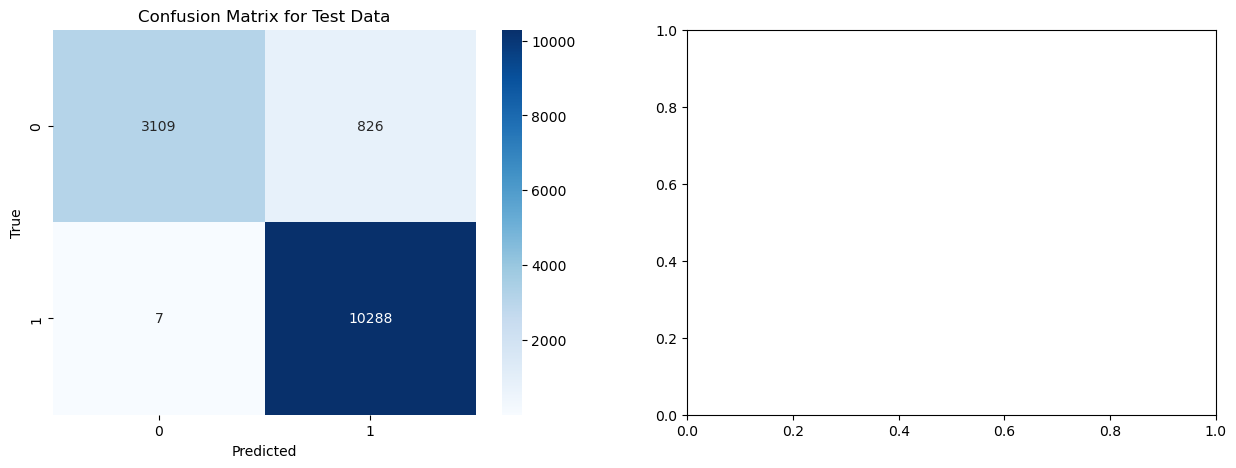

In [47]:
#train and test the model
X,y=Xy44.iloc[:,2:-1],Xy44.iloc[:,-1]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_attribs = X.select_dtypes(include=['object']).columns.tolist()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

# Fit the pipeline on training data and transform both training and test data
encoder = full_pipeline.fit(X_train_raw)
X_train = encoder.transform(X_train_raw)
X_test = encoder.transform(X_test_raw)


classes_weights = class_weight.compute_sample_weight(class_weight={0:1,1:3},y=y_train)
xgb_clf = XGBClassifier(max_depth=7,learning_rate=0.1,n_estimators=200,max_delta_step=0,subsample=0.8,colsample_bytree=0.8,colsample_bylevel=1,random_state=42,seed=None,)
xgb_clf.fit(X_train,y_train,sample_weight=classes_weights)

y_pred = xgb_clf.predict(X_test)
y_pred_train = xgb_clf.predict(X_train)


print("-----------train------------")
print(confusion_matrix(y_train, y_pred_train),accuracy_score(y_train, y_pred_train))
print("-----------test------------")
print(confusion_matrix(y_test, y_pred),accuracy_score(y_test, y_pred))#,roc_auc_score(y_test, y_pred),custom_loss(y_test, y_pred),recall_score(y_test, y_pred),accuracy_score(y_test, y_pred),f1_score(y_test, y_pred),precision_score(y_test, y_pred))


#save the result
results_test_df = pd.concat([pd.concat([X_test_raw, y_test],axis=1).reset_index(drop=True),pd.DataFrame(y_pred,columns=["predict"])],axis=1)
results_test_df.to_csv('results_test_lentils.csv', index=False)

#visulize the result
import seaborn as sns
import matplotlib.pyplot as plt

cm1 = confusion_matrix(y_test, y_pred)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix for Test Data')




In [48]:
# try different algorithms
placeholder_value = -999  # Choose a suitable placeholder value
X_train = np.where(np.isnan(X_train), placeholder_value, X_train)
X_test= np.where(np.isnan(X_test), placeholder_value, X_test)


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


classifiers = {
    'XGBoost': XGBClassifier(),
#     'CatBoost': CatBoostClassifier(),
#     'Random Forest': RandomForestClassifier(),
#     'SVM': SVC(),
#     'Logistic Regression': LogisticRegression(),   
#     'LightGBM': LGBMClassifier(),
}

for name, clf in classifiers.items():
    print(f"Using {name} classifier:")
    
   
    clf.fit(X_train, y_train, sample_weight=classes_weights)
    

    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
  
    

    print("Test set:")
    print(confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred))
    
    print("Training set:")
    print(confusion_matrix(y_train, y_pred_train), accuracy_score(y_train, y_pred_train))
    

    
    print('-' * 40)


Using XGBoost classifier:
Test set:
[[ 3109   826]
 [    7 10288]] 0.9414617006324666
Training set:
[[12463  3342]
 [   12 41102]] 0.94107415801402
----------------------------------------
